In [1]:
#!pip install keras==2.3.1  
#!pip uninstall opencv-python -y
#!pip install opencv-contrib-python==3.4.2.17 --force-reinstall
from matplotlib.pyplot import imshow
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from numpy import asarray
from pathlib import Path
import cv2
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Flatten,BatchNormalization,Dense,Dropout
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D,MaxPooling2D,ZeroPadding2D
from keras.utils import np_utils,to_categorical
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.regularizers import l2
from numpy import load
from numpy import savez_compressed
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import svm
import seaborn as sn
from google.colab import drive
import random

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
directory = '/content/drive/My Drive/CMPE255/src/'

In [0]:
fer_data=pd.read_csv(directory+'Data/fer2013.csv',delimiter=',')

In [0]:
def load_data(fer_data):
    train_images = []
    test_images = []
    train_labels = []
    test_labels = []
    for index,row in fer_data.iterrows():
        pixels=np.asarray(list(row['pixels'].split(' ')),dtype=np.uint8)
        img=pixels.reshape((48,48))
        if row['Usage'] == 'Training':
          train_labels.append(row['emotion'])
          train_images.append(img)
        else :
          test_labels.append(row['emotion'])
          test_images.append(img)
    return (train_images,test_images,train_labels,test_labels)

---
##**Load the data from the CSV**
---






In [6]:
%time X_train, X_test, y_train, y_test = load_data(fer_data)

CPU times: user 19.4 s, sys: 650 ms, total: 20 s
Wall time: 20 s


In [0]:
def plot_images(data,label):
  emotion = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happy', 4 :'Sad', 5 : 'Surprise', 6 : 'Neutral'}
  f, axarr = plt.subplots(2,2,constrained_layout=True)
  axarr[0,0].imshow(data[0])
  axarr[0,0].set_title(emotion[label[0]])
  axarr[0,1].imshow(data[1])
  axarr[0,1].set_title(emotion[label[1]])
  axarr[1,0].imshow(data[2])
  axarr[1,0].set_title(emotion[label[2]])
  axarr[1,1].imshow(data[3])
  axarr[1,1].set_title(emotion[label[3]])

##Visualise four randomly selected images from the dataset

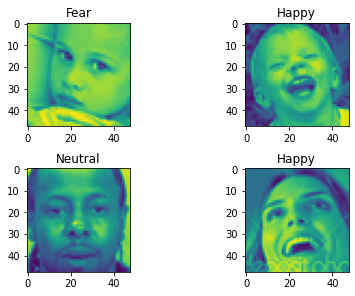

In [8]:
#randomly select 4 images
idx = np.random.choice(len(X_train),4,False)
plot_images([X_train[i] for i in idx] ,[y_train[i] for i in idx])

In [0]:
X_train = np.expand_dims(np.array(X_train),-1) 
X_test = np.expand_dims(np.array(X_test),-1)

##Perform min-max normalization

In [0]:
#min-max normalization
X_train = X_train / 255.0
X_test = X_test / 255.0

##Split the training data into training data and validation data

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,stratify=y_train, test_size=0.2, random_state=42)

In [12]:
print("Train Set : " ,len(y_train),"images")
print("Test Set : " ,len(y_test),"images")
print("Validation Set : " ,len(y_val),"images")

Train Set :  22967 images
Test Set :  7178 images
Validation Set :  5742 images


In [0]:
def plot_bar(data):
    label = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']
    index = np.arange(len(label))
    plt.bar(index, data)
    plt.xlabel('Emotion', fontsize=15)
    plt.ylabel('No of samples', fontsize=15)
    plt.xticks(index, label, fontsize=15, rotation=30)
    plt.show()

##Plot the count of images belonging to each class

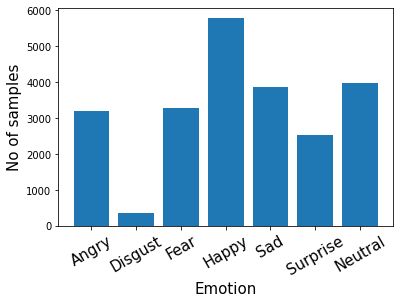

In [14]:
plot_bar(np.bincount(y_train))
y_train = to_categorical(y_train)

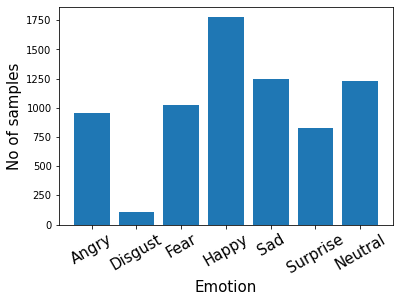

In [15]:
plot_bar(np.bincount(y_test))
y_test = to_categorical(y_test)

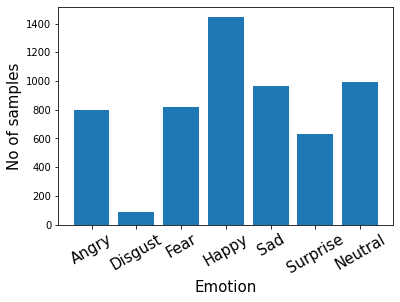

In [16]:
plot_bar(np.bincount(y_val))
y_val = to_categorical(y_val)

##Build the Convolutional Neural Network

In [17]:
img_width=48
img_height=48
num_classes=7

# Create the model
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(img_width, img_height, 1)))
model.add(Conv2D(64, (3, 3) , padding='same', activation='relu', kernel_constraint=maxnorm(3)))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(ZeroPadding2D((1,1)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_constraint=maxnorm(3)))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_constraint=maxnorm(3)))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_constraint=maxnorm(3)))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_constraint=maxnorm(3)))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(ZeroPadding2D((1,1)))
model.add(MaxPooling2D())

model.add(Conv2D(512, (3, 3), activation='relu', padding='same', kernel_constraint=maxnorm(3)))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', kernel_constraint=maxnorm(3)))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', kernel_constraint=maxnorm(3)))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile model
epochs = 200
lrate = 0.01
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)

#load weights
#model.load_weights(directory+"/Models/weights-improvement-23-0.56.hdf5")

model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 50, 50, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 27, 27, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 27, 27, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 64)       

In [0]:
# checkpoint
filepath= directory+"/Models/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max',period=10)
earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=40,restore_best_weights=True)
callbacks_list = [checkpoint,earlystop]

##Train the model

In [19]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

validationgen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train)
validationgen.fit(X_val)

# fits the model on batches with real-time data augmentation:
model.fit_generator(datagen.flow(X_train, y_train, batch_size=10),steps_per_epoch=len(X_train) / 10,
                    epochs=epochs, callbacks=callbacks_list, validation_data=validationgen.flow(X_val,y_val),validation_steps=len(X_val)/ 10)

Epoch 1/200
2297/2296 [==============================] - 70s 30ms/step - loss: 1.8122 - accuracy: 0.2490 - val_loss: 1.8602 - val_accuracy: 0.2515
Epoch 2/200
2297/2296 [==============================] - 62s 27ms/step - loss: 1.7956 - accuracy: 0.2514 - val_loss: 1.8477 - val_accuracy: 0.2528
Epoch 3/200
2297/2296 [==============================] - 62s 27ms/step - loss: 1.7821 - accuracy: 0.2583 - val_loss: 1.8493 - val_accuracy: 0.2587
Epoch 4/200
2297/2296 [==============================] - 62s 27ms/step - loss: 1.7312 - accuracy: 0.2864 - val_loss: 1.7769 - val_accuracy: 0.2911
Epoch 5/200
2297/2296 [==============================] - 62s 27ms/step - loss: 1.6837 - accuracy: 0.3084 - val_loss: 1.6029 - val_accuracy: 0.3166
Epoch 6/200
2297/2296 [==============================] - 62s 27ms/step - loss: 1.6468 - accuracy: 0.3272 - val_loss: 1.6189 - val_accuracy: 0.3572
Epoch 7/200
2297/2296 [==============================] - 62s 27ms/step - loss: 1.5681 - accuracy: 0.3680 - val_loss: 1

##Evaluate the model on test data

In [20]:
# Final evaluation of the model
datagen.standardize(X_test)
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 64.35%


In [0]:
y_pred = model.predict_classes(X_test)
matrix = confusion_matrix(np.argmax(y_test, axis=1),y_pred,normalize='true')

##Plot the confusion matrix

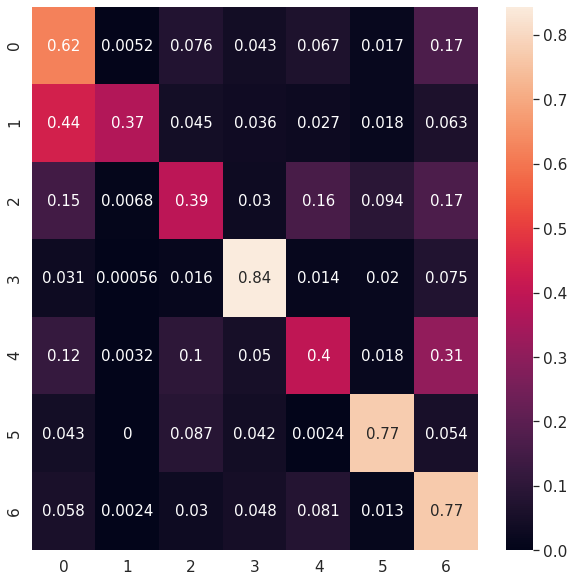

In [22]:
df_cm = pd.DataFrame(matrix,range(matrix.shape[0]),range(matrix.shape[1]))
plt.figure(figsize = (10,10))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 15})